In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim
import pickle

In [2]:
sr=None
n_fft=2048
hop_length=512
alpha=0.98
s_f=0.98
pvariance=1e-2
mvariance=0.001

In [3]:
def load_audio(file_path,sr=None,mono=True):
    y,sr=librosa.load(file_path,sr=sr,mono=mono)
    return y,sr
def plot_spect(y,sr,filepath):
    plt.figure(figsize=(8,6))
    d=librosa.amplitude_to_db(np.abs(librosa.stft(y)),ref=np.max)
    librosa.display.specshow(d,sr=sr,x_axis='time',y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(filepath,format='png',dpi=300)
    plt.close()
def plot_spectrogram(y,sr,title='Spectrogram'):
    plt.figure(figsize=(8,6))
    d=librosa.amplitude_to_db(librosa.stft(y),ref=np.max)
    librosa.display.specshow(d,sr=sr,x_axis='time',y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()
def compute_snr(clean_signal,denoised_signal):
    min_len=min(len(clean_signal),len(denoised_signal))
    clean_signal=clean_signal[:min_len]
    denoised_signal=denoised_signal[:min_len]
    noise=denoised_signal-clean_signal
    snr=10*np.log10(np.sum(clean_signal**2)/np.sum(noise**2))
    return snr
def snr(signal,clean_signal,denoised_signal):
    snr_b=10*np.log10(np.sum(clean_signal ** 2)/np.sum((signal - clean_signal)**2))
    snr_a=compute_snr(clean_signal,denoised_signal)
    snr_i=(snr_a-snr_b)/snr_b
    return snr_i
def compute_psnr(clean_signal,denoised_signal):
    min_len=min(len(clean_signal), len(denoised_signal))
    clean_signal=clean_signal[:min_len]
    denoised_signal=denoised_signal[:min_len]
    mse=np.mean((clean_signal-denoised_signal)**2)
    MAX=np.max(np.abs(clean_signal))
    if MAX == 0:
        return float('inf')
    psnr=10*np.log10(MAX**2/mse)
    return psnr
def psnr(signal,clean_signal,denoised_signal):
    psnr_b=compute_psnr(clean_signal, signal)
    psnr_a=compute_psnr(clean_signal, denoised_signal)
    psnr_i=(psnr_a-psnr_b)/psnr_b
    return psnr_i
def compute_ssim(clean_signal,denoised_signal):
    min_len=min(len(clean_signal),len(denoised_signal))
    clean_signal=clean_signal[:min_len]
    denoised_signal=denoised_signal[:min_len]
    ssim_value=ssim(clean_signal,denoised_signal,data_range=1.0)
    return ssim_value
def ssimim(signal, clean_signal, denoised_signal):
    ssim_b=compute_ssim(clean_signal,signal) 
    ssim_a=compute_ssim(clean_signal,denoised_signal) 
    ssim_i=(ssim_a-ssim_b)/(ssim_b+1e-10)
    return ssim_i

In [4]:
def estimate_noise_psd(signal,sr,n_fft=2048,hop_length=512):
    noise=signal
    stft=librosa.stft(noise,n_fft=n_fft,hop_length=hop_length)
    psd=np.mean(np.abs(stft)**2,axis=1)
    return psd
def compute_wiener_gain(mag,psd):
    signal_psd=np.maximum(mag**2-psd[:,np.newaxis],1e-10)
    gain=signal_psd/(signal_psd+psd[:,np.newaxis])
    return gain
def apply_wiener_filter(signal,psd,n_fft=2048,hop_length=512):
    stft=librosa.stft(signal,n_fft=n_fft,hop_length=hop_length)
    mag,phase=np.abs(stft),np.angle(stft)
    gain=compute_wiener_gain(mag,psd)
    stft=gain*stft
    istft=librosa.istft(stft,hop_length=hop_length)
    return istft
def wiener_filter(signal,sr,n_fft,hop_length):
    psd=estimate_noise_psd(signal,sr,n_fft=n_fft,hop_length=hop_length)
    denoised_signal=apply_wiener_filter(signal,psd,n_fft=n_fft,hop_length=hop_length)
    return denoised_signal

In [5]:
def kalman_filter(signal,pvariance=1e-7,mvariance=0.01):
  estimate=np.zeros_like(signal)
  error=np.ones_like(signal)
  gain=np.zeros_like(signal)
  estimate[0]=signal[0]
  error[0]=0.1
  for t in range(1,len(signal)):
    error[t]=error[t-1]+pvariance
    gain[t]=error[t]/(error[t]+mvariance)
    estimate[t]=estimate[t-1]+gain[t]*(signal[t]-estimate[t-1])
    error[t]=(1-gain[t])*error[t]
  return estimate
def apply_kalman_filter(signal,sr,n_fft=2048,hop_length=512,pvariance=1e-5,mvariance=0.1):
   stft=librosa.stft(signal,n_fft=n_fft,hop_length=hop_length)
   mag,phase=np.abs(stft),np.angle(stft)
   denoised=np.array([kalman_filter(mag[f, :],pvariance,mvariance)
                                   for f in range(mag.shape[0])])
   stft=denoised*np.exp(1j*phase)
   istft=librosa.istft(stft, hop_length=hop_length)
   return istft

In [6]:
def estimate_noise_psd(signal,sr,n_fft=2048,hop_length=512):
    noise=signal
    stft=librosa.stft(noise,n_fft=n_fft,hop_length=hop_length)
    psd=np.mean(np.abs(stft)**2,axis=1)
    return psd
def compute_a_priori_snr(mag,psd,alpha=0.98):
    gamma=mag**2/psd[:,np.newaxis]
    xi_prev=np.maximum(gamma-1,0)
    xi=alpha*xi_prev+(1-alpha)*np.maximum(gamma-1,0)
    return xi
def compute_mmse_lsa_gain(xi):
    sf=0.98
    xi=np.maximum(xi,1e-10)
    gain=(sf*xi)/(1+xi)
    return gain
def apply_mmse_lsa_filter(signal,psd,n_fft=2048,hop_length=512,alpha=0.98,sf=0.98):
    stft=librosa.stft(signal,n_fft=n_fft,hop_length=hop_length)
    mag,phase=np.abs(stft),np.angle(stft)
    xi=compute_a_priori_snr(mag,psd,alpha=alpha)
    gain=compute_mmse_lsa_gain(xi)
    stft=gain*stft
    istft=librosa.istft(stft,hop_length=hop_length)
    return istft
def mmse(signal,sr,n_fft,hop_length,alpha,sf):
    psd=estimate_noise_psd(signal,sr,n_fft=n_fft,hop_length=hop_length)
    denoised_signal=apply_mmse_lsa_filter(signal,psd,n_fft=n_fft,hop_length=hop_length,alpha=alpha,sf=sf)
    return denoised_signal

In [7]:
import soundfile as sf
wiener_snr=[]
mmse_snr=[]
kalman_snr=[]
wiener_psnr=[]
mmse_psnr=[]
kalman_psnr=[]
wiener_ssim=[]
mmse_ssim=[]
kalman_ssim=[]
image_noisy_name='Noise spectrograms'
image_noisy_dir=os.path.join('/kaggle/working',image_noisy_name)
if not os.path.exists(image_noisy_dir):
    os.makedirs(image_noisy_dir)
image_clean_name='Clean spectrograms'
image_clean_dir=os.path.join('/kaggle/working',image_clean_name)
if not os.path.exists(image_clean_dir):
    os.makedirs(image_clean_dir)
image_wiener_name='Wiener Denoised spectrograms'
image_wiener_dir=os.path.join('/kaggle/working',image_wiener_name)
if not os.path.exists(image_wiener_dir):
    os.makedirs(image_wiener_dir)
image_kalman_name='Kalman Denoised spectrograms'
image_kalman_dir=os.path.join('/kaggle/working',image_kalman_name)
if not os.path.exists(image_kalman_dir):
    os.makedirs(image_kalman_dir)
image_mmse_name='MMSE Denoised spectrograms'
image_mmse_dir=os.path.join('/kaggle/working',image_mmse_name)
if not os.path.exists(image_mmse_dir):
    os.makedirs(image_mmse_dir)
wiener_name='Wiener denoised audio'
wiener_dir=os.path.join('/kaggle/working',wiener_name)
if not os.path.exists(wiener_dir):
    os.makedirs(wiener_dir)
kalman_name='Kalman denoised audio'
kalman_dir=os.path.join('/kaggle/working',kalman_name)
if not os.path.exists(kalman_dir):
    os.makedirs(kalman_dir)
mmse_name='MMSE denoised audio'
mmse_dir=os.path.join('/kaggle/working',mmse_name)
if not os.path.exists(mmse_dir):
    os.makedirs(mmse_dir)
for root,dirs,files in os.walk('/kaggle/input/audio-dataset/Dataset/noisy dataset'):
    for file in files:
        noise=os.path.join(root,file)
        signal,sr=load_audio(noise,sr=sr,mono=True)
        clean=os.path.join('/kaggle/input/audio-dataset/Dataset/clean dataset',file)
        clean_signal,_=load_audio(clean,sr=sr,mono=True)
        plot_spect(signal,sr,f"{image_noisy_dir}/{file.rsplit('.', 1)[0]}.png")
        plot_spect(clean_signal,sr,f"{image_clean_dir}/{file.rsplit('.', 1)[0]}.png")
        wiener_denoised_signal=wiener_filter(signal,sr,n_fft,hop_length)
        wiener_snri=snr(signal,clean_signal,wiener_denoised_signal)
        wiener_snr.append(wiener_snri)
        wiener_psnri=psnr(signal,clean_signal,wiener_denoised_signal)
        wiener_psnr.append(wiener_psnri)
        wiener_ssimi=ssimim(signal,clean_signal,wiener_denoised_signal)
        wiener_ssim.append(wiener_ssimi)
        plot_spect(wiener_denoised_signal,sr,f"{image_wiener_dir}/{file.rsplit('.', 1)[0]}.png")
        sf.write(f"{wiener_dir}/{file.rsplit('.', 1)[0]}.wav",wiener_denoised_signal,sr)
        kalman_denoised_signal=apply_kalman_filter(signal,sr,n_fft=n_fft,hop_length=hop_length,pvariance=pvariance,mvariance=mvariance)
        kalman_snri=snr(signal,clean_signal,kalman_denoised_signal)
        kalman_snr.append(kalman_snri)
        kalman_psnri=psnr(signal,clean_signal,kalman_denoised_signal)
        kalman_psnr.append(kalman_psnri)
        kalman_ssimi=ssimim(signal,clean_signal,kalman_denoised_signal)
        kalman_ssim.append(kalman_ssimi)
        plot_spect(kalman_denoised_signal,sr,f"{image_kalman_dir}/{file.rsplit('.', 1)[0]}.png")
        sf.write(f"{kalman_dir}/{file.rsplit('.', 1)[0]}.wav",kalman_denoised_signal,sr)
        mmse_denoised_signal=mmse(signal,sr,n_fft,hop_length,alpha,s_f)
        mmse_snri=snr(signal,clean_signal,mmse_denoised_signal)
        mmse_snr.append(mmse_snri)
        mmse_psnri=psnr(signal,clean_signal,mmse_denoised_signal)
        mmse_psnr.append(mmse_psnri)
        mmse_ssimi=ssimim(signal,clean_signal,mmse_denoised_signal)
        mmse_ssim.append(mmse_ssimi)
        plot_spect(mmse_denoised_signal,sr,f"{image_mmse_dir}/{file.rsplit('.', 1)[0]}.png")
        sf.write(f"{mmse_dir}/{file.rsplit('.', 1)[0]}.wav",mmse_denoised_signal,sr)

In [8]:
print(f"Average Kalman SNR improvement artio: {sum(kalman_snr)/len(kalman_snr):.2f} dB")
print(f"Average Wiener SNR improvement ratio: {sum(wiener_snr)/len(wiener_snr):.2f} dB")
print(f"Averegae MMSE-LSA SNR improvement ratio: {sum(mmse_snr)/len(mmse_snr):.2f} dB")
print(f"Average Kalman PSNR improvement artio: {sum(kalman_psnr)/len(kalman_psnr):.2f} dB")
print(f"Average Wiener PSNR improvement ratio: {sum(wiener_psnr)/len(wiener_psnr):.2f} dB")
print(f"Averegae MMSE-LSA PSNR improvement ratio: {sum(mmse_psnr)/len(mmse_psnr):.2f} dB")
print(f"Average Kalman SSIM improvement artio: {sum(kalman_ssim)/len(kalman_ssim):.2f} dB")
print(f"Average Wiener SSIM improvement ratio: {sum(wiener_ssim)/len(wiener_ssim):.2f} dB")
print(f"Averegae MMSE-LSA SSIM improvement ratio: {sum(mmse_ssim)/len(mmse_ssim):.2f} dB")

Average Kalman SNR improvement artio: 0.04 dB
Average Wiener SNR improvement ratio: 1.73 dB
Averegae MMSE-LSA SNR improvement ratio: 1.72 dB
Average Kalman PSNR improvement artio: 0.00 dB
Average Wiener PSNR improvement ratio: 0.02 dB
Averegae MMSE-LSA PSNR improvement ratio: 0.02 dB
Average Kalman SSIM improvement artio: 0.00 dB
Average Wiener SSIM improvement ratio: 0.32 dB
Averegae MMSE-LSA SSIM improvement ratio: 0.32 dB


/tmp/ipykernel_17/2502320365.py:14: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  d=librosa.amplitude_to_db(librosa.stft(y),ref=np.max)


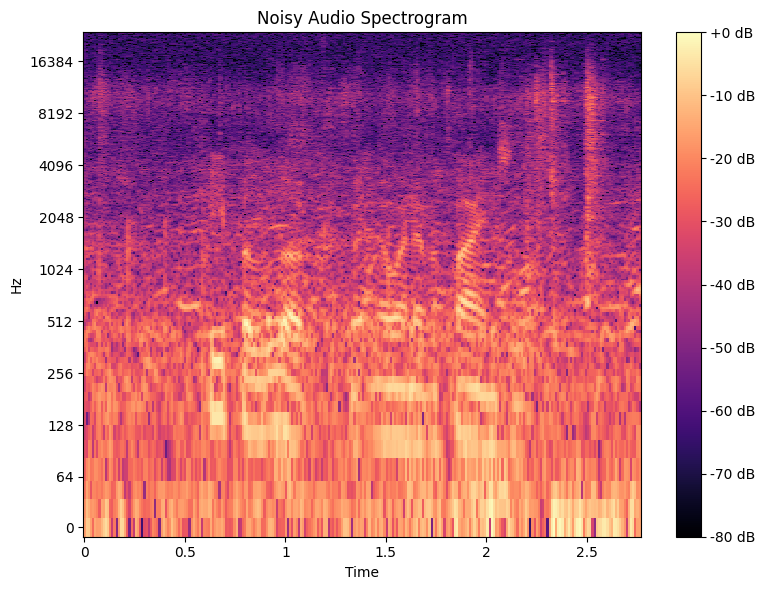

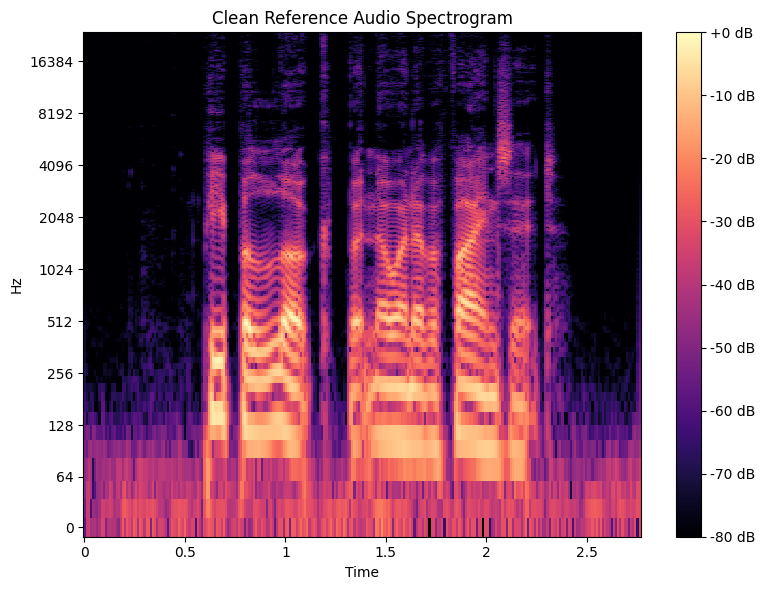

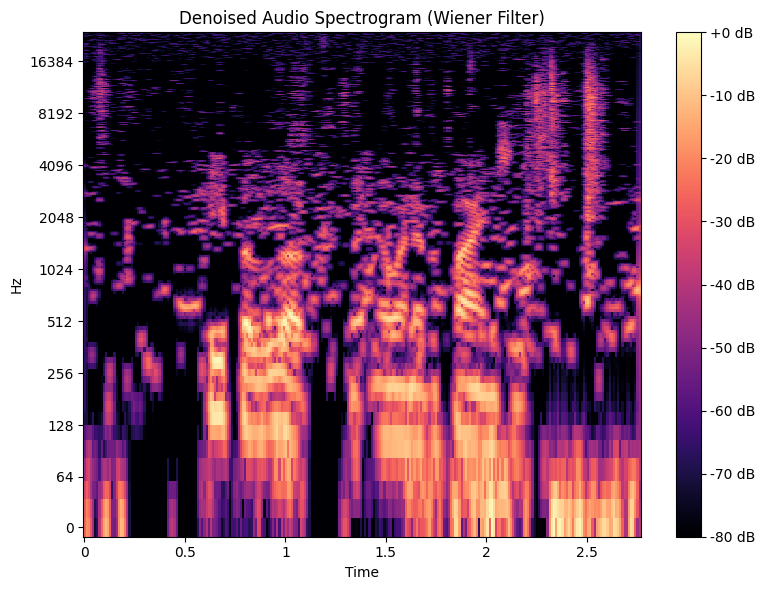

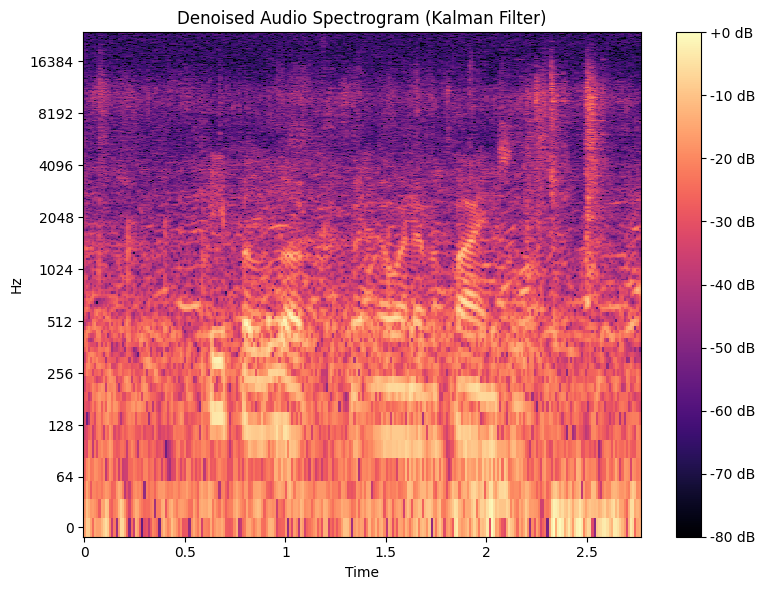

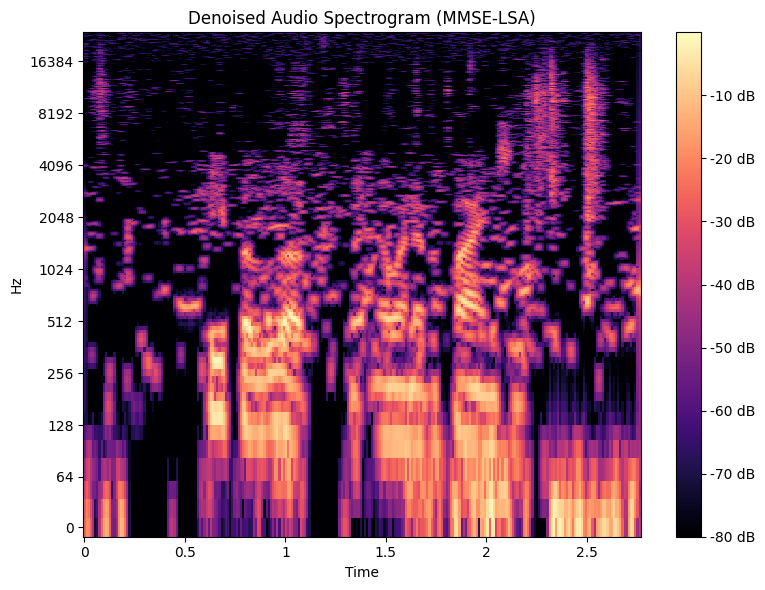

In [9]:
import soundfile as sf
signal,sr=load_audio(noise,sr=sr,mono=True)
clean_signal,clean_sr=load_audio(clean,sr=sr,mono=True)
plot_spectrogram(signal,sr,title='Noisy Audio Spectrogram')
plot_spectrogram(clean_signal,clean_sr,title='Clean Reference Audio Spectrogram')
wiener_denoised_signal=wiener_filter(signal,sr,n_fft=n_fft,hop_length=hop_length)
wiener_snri=compute_snr(clean_signal,wiener_denoised_signal)
wiener_psnri=compute_psnr(clean_signal,wiener_denoised_signal)
wiener_ssimi=compute_ssim(clean_signal,wiener_denoised_signal)
plot_spectrogram(wiener_denoised_signal,sr,title='Denoised Audio Spectrogram (Wiener Filter)')
kalman_denoised_signal=apply_kalman_filter(signal,sr,n_fft=n_fft,hop_length=hop_length,pvariance=pvariance,mvariance=mvariance)
kalman_snri=compute_snr(clean_signal,kalman_denoised_signal)
kalman_psnri=compute_psnr(clean_signal,kalman_denoised_signal)
kalman_ssimi=compute_ssim(clean_signal,kalman_denoised_signal)
plot_spectrogram(kalman_denoised_signal,sr,title='Denoised Audio Spectrogram (Kalman Filter)')
mmse_denoised_signal=mmse(signal,sr,n_fft,hop_length,alpha,sf)
mmse_snri=compute_snr(clean_signal,mmse_denoised_signal)
mmse_psnri=compute_psnr(clean_signal,mmse_denoised_signal)
mmse_ssimi=compute_ssim(clean_signal,mmse_denoised_signal)
plot_spectrogram(mmse_denoised_signal,sr,title='Denoised Audio Spectrogram (MMSE-LSA)')

In [10]:
print(f"Wiener SNR : {wiener_snri}")
print(f"Kalman SNR : {kalman_snri}")
print(f"MMSE-LSA SNR : {mmse_snri}")
print(f"Wiener PSNR : {wiener_psnri}")
print(f"Kalman PSNR : {kalman_psnri}")
print(f"MMSE-LSA PSNR : {mmse_psnri}")
print(f"Wiener SSIM : {wiener_ssimi}")
print(f"Kalman SSIM : {kalman_ssimi}")
print(f"MMSE-LSA SSIM : {mmse_ssimi}")

Wiener SNR : 4.330882430076599
Kalman SNR : 0.8586692065000534
MMSE-LSA SNR : 4.38073456287384
Wiener PSNR : 20.738878351860368
Kalman PSNR : 17.26666548202161
MMSE-LSA PSNR : 20.788731279129372
Wiener SSIM : 0.4940481718029422
Kalman SSIM : 0.288900348530938
MMSE-LSA SSIM : 0.4958296713927945


In [11]:
!zip -r /kaggle/working/working_directory.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/Clean spectrograms/ (stored 0%)
  adding: kaggle/working/Clean spectrograms/p232_010.png (deflated 6%)
  adding: kaggle/working/Clean spectrograms/p232_073.png (deflated 7%)
  adding: kaggle/working/Clean spectrograms/p232_103.png (deflated 4%)
  adding: kaggle/working/Clean spectrograms/p232_024.png (deflated 3%)
  adding: kaggle/working/Clean spectrograms/p232_060.png (deflated 7%)
  adding: kaggle/working/Clean spectrograms/p232_087.png (deflated 7%)
  adding: kaggle/working/Clean spectrograms/p232_052.png (deflated 6%)
  adding: kaggle/working/Clean spectrograms/p232_037.png (deflated 4%)
  adding: kaggle/working/Clean spectrograms/p232_017.png (deflated 5%)
  adding: kaggle/working/Clean spectrograms/p232_049.png (deflated 5%)
  adding: kaggle/working/Clean spectrograms/p232_089.png (deflated 6%)
  adding: kaggle/working/Clean spectrograms/p232_043.png (deflated 7%)
  adding: kaggle/working/Clean spectrograms/p232_085.